<a href="https://colab.research.google.com/github/ffelicioni/tp_infoviz/blob/main/EDA_VC_social_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis del archivo de SocialNetworks

## Modulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Funciones

In [23]:
def preparar_matriz_adyacencia(df):
    n=np.max(df.participantIdTo)+1
    mat_ady = np.zeros([n, n], dtype = int)
    df2=df.copy()
    df2['index_from'] = df2[['participantIdFrom','participantIdTo']].min(axis=1)
    df2['index_to'] = df2[['participantIdFrom','participantIdTo']].max(axis=1)
    df2=df2[['index_from','index_to','month']].groupby(['index_from','index_to']).count()
    for i in range(0,len(df2.month.values)):
        valores=df2.month.values[i]
        indices=np.array([df2.month.index[i][0],df2.month.index[i][1]])
        mat_ady[indices[0]][indices[1]]=valores
    
    mat_ady=mat_ady+mat_ady.T
    return mat_ady



def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

## Datasets

In [3]:
path='https://raw.githubusercontent.com/ffelicioni/tp_infoviz/main/data'
participants=pd.read_csv(path+"/Attributes/Participants.csv")
participants

,participantId,householdSize,haveKids,age,educationLevel,interestGroup,joviality
0,0,3,True,36,HighSchoolOrCollege,H,0.001627
1,1,3,True,25,HighSchoolOrCollege,B,0.328087
2,2,3,True,35,HighSchoolOrCollege,A,0.393470
3,3,3,True,21,HighSchoolOrCollege,I,0.138063
4,4,3,True,43,Bachelors,H,0.857397
...,...,...,...,...,...,...,...
1006,1006,1,False,19,HighSchoolOrCollege,J,0.639268
1007,1007,1,False,40,HighSchoolOrCollege,B,0.934348
1008,1008,1,False,23,Graduate,C,0.163721
1009,1009,1,False,39,Low,B,0.828330


Descomprimo dataset de SocialNetwork

In [4]:
!wget https://raw.githubusercontent.com/ffelicioni/tp_infoviz/main/data/Journals/SocialNetwork.zip
!unzip /content/SocialNetwork.zip

--2022-05-29 20:41:08--  https://raw.githubusercontent.com/ffelicioni/tp_infoviz/main/data/Journals/SocialNetwork.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25575878 (24M) [application/zip]
Saving to: ‘SocialNetwork.zip.1’

SocialNetwork.zip.1 100%[===================>]  24.39M  70.4MB/s    in 0.3s    

2022-05-29 20:41:08 (70.4 MB/s) - ‘SocialNetwork.zip.1’ saved [25575878/25575878]

Archive:  /content/SocialNetwork.zip
replace SocialNetwork.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SocialNetwork.csv       


In [5]:
social_network=pd.read_csv("./SocialNetwork.csv",parse_dates=['timestamp'])#,index_col='timestamp')
social_network.dtypes

timestamp            datetime64[ns, UTC]
participantIdFrom                  int64
participantIdTo                    int64
dtype: object

In [6]:
social_network

,timestamp,participantIdFrom,participantIdTo
0,2022-03-01 00:00:00+00:00,173,180
1,2022-03-01 00:00:00+00:00,178,183
2,2022-03-01 00:00:00+00:00,178,185
3,2022-03-01 00:00:00+00:00,180,173
4,2022-03-01 00:00:00+00:00,183,178
...,...,...,...
7482483,2023-05-25 00:00:00+00:00,879,102
7482484,2023-05-25 00:00:00+00:00,879,851
7482485,2023-05-25 00:00:00+00:00,879,412
7482486,2023-05-25 00:00:00+00:00,879,17


### The day of the week with Monday=0, Sunday=6.

In [7]:
# agrego datos respecto del día
social_network['week']=social_network.timestamp.dt.isocalendar().week
social_network['day_of_week']=social_network.timestamp.dt.dayofweek
social_network['days_in_month']=social_network.timestamp.dt.days_in_month
social_network['month']=social_network.timestamp.dt.month
social_network['year']=social_network.timestamp.dt.year
social_network

,timestamp,participantIdFrom,participantIdTo,week,day_of_week,days_in_month,month,year
0,2022-03-01 00:00:00+00:00,173,180,9,1,31,3,2022
1,2022-03-01 00:00:00+00:00,178,183,9,1,31,3,2022
2,2022-03-01 00:00:00+00:00,178,185,9,1,31,3,2022
3,2022-03-01 00:00:00+00:00,180,173,9,1,31,3,2022
4,2022-03-01 00:00:00+00:00,183,178,9,1,31,3,2022
...,...,...,...,...,...,...,...,...
7482483,2023-05-25 00:00:00+00:00,879,102,21,3,31,5,2023
7482484,2023-05-25 00:00:00+00:00,879,851,21,3,31,5,2023
7482485,2023-05-25 00:00:00+00:00,879,412,21,3,31,5,2023
7482486,2023-05-25 00:00:00+00:00,879,17,21,3,31,5,2023


## agrupo comunicaciones por día

In [8]:
comunicacion_diaria=social_network[['timestamp','participantIdFrom']].groupby(['timestamp']).count()
comunicacion_diaria.rename(columns = {'participantIdFrom':'total'}, inplace = True)
comunicacion_diaria.reset_index(inplace=True)
comunicacion_diaria['week']=comunicacion_diaria.timestamp.dt.isocalendar().week
comunicacion_diaria['days_in_month']=comunicacion_diaria.timestamp.dt.days_in_month
comunicacion_diaria['day_of_week']=comunicacion_diaria.timestamp.dt.dayofweek
comunicacion_diaria['month']=comunicacion_diaria.timestamp.dt.month
comunicacion_diaria['year']=comunicacion_diaria.timestamp.dt.year
comunicacion_diaria=comunicacion_diaria.set_index('timestamp')
comunicacion_diaria

,total,week,days_in_month,day_of_week,month,year
timestamp,,,,,,
2022-03-01 00:00:00+00:00,194,9,31,1,3,2022
2022-03-02 00:00:00+00:00,1218,9,31,2,3,2022
2022-03-03 00:00:00+00:00,1802,9,31,3,3,2022
2022-03-04 00:00:00+00:00,2226,9,31,4,3,2022
2022-03-05 00:00:00+00:00,2556,9,31,5,3,2022
...,...,...,...,...,...,...
2023-05-21 00:00:00+00:00,17530,20,31,6,5,2023
2023-05-22 00:00:00+00:00,18674,21,31,0,5,2023
2023-05-23 00:00:00+00:00,18462,21,31,1,5,2023


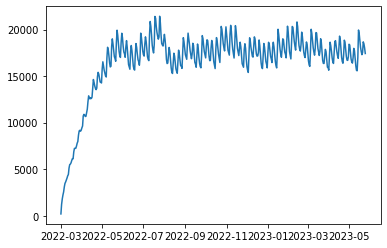

In [9]:
plt.plot(comunicacion_diaria['total'])

aunmentan las comunicaciones a partir de mayo de 2022, a partir de lo cual empiezan a oscilar en torno a un valor promedio

In [10]:
fecha_ini='2022-05-01 00:00:00+00:00'
df1=comunicacion_diaria[comunicacion_diaria.index>=fecha_ini]

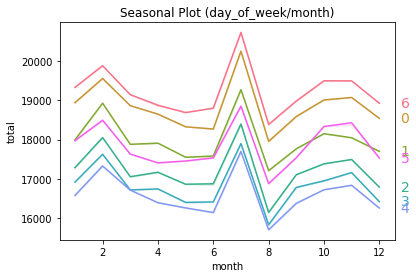

In [11]:
seasonal_plot(df1, y='total', period='day_of_week', freq='month');

## Si se quiere seleccionar por algún mes/año o condición

In [24]:
df=social_network[(social_network.timestamp>=fecha_ini)]
# (social_network.month==4) & (social_network.year==2022)
df

,timestamp,participantIdFrom,participantIdTo,week,day_of_week,days_in_month,month,year
556428,2022-05-01 00:00:00+00:00,0,709,17,6,31,5,2022
556429,2022-05-01 00:00:00+00:00,0,524,17,6,31,5,2022
556430,2022-05-01 00:00:00+00:00,1,171,17,6,31,5,2022
556431,2022-05-01 00:00:00+00:00,1,708,17,6,31,5,2022
556432,2022-05-01 00:00:00+00:00,1,366,17,6,31,5,2022
...,...,...,...,...,...,...,...,...
7482483,2023-05-25 00:00:00+00:00,879,102,21,3,31,5,2023
7482484,2023-05-25 00:00:00+00:00,879,851,21,3,31,5,2023
7482485,2023-05-25 00:00:00+00:00,879,412,21,3,31,5,2023
7482486,2023-05-25 00:00:00+00:00,879,17,21,3,31,5,2023


In [13]:
#np.unique(df.participantIdTo)

Armo matriz de adyacencia de las comunicaciones. Considero la cantidad de mensajes que hubo entre los participantes (son los pesos)

In [26]:
mat_ady=preparar_matriz_adyacencia(df)
print(mat_ady)

[[  0   0   0 ...   0   0   0]
 [  0   0  32 ...   0   0   0]
 [  0  32   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 140]
 [  0   0   0 ...   0 140   0]]


Text(0.5, 0.98, 'Matriz Adyacencia')

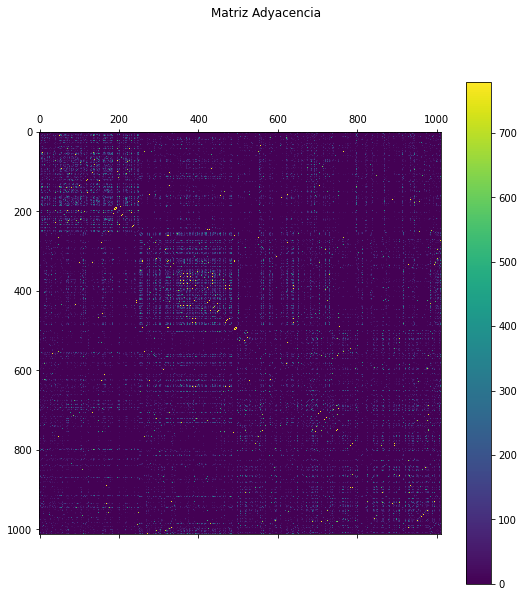

In [27]:
plt.figure(figsize=(9, 9))
plt.matshow(mat_ady, fignum=1)
plt.colorbar()
plt.suptitle('Matriz Adyacencia')

In [28]:
G = nx.from_numpy_matrix(mat_ady)

In [29]:
print(nx.info(G))
print('Is weigthed:',nx.is_weighted(G))

G.number_of_nodes(), G.number_of_edges()

Graph with 1011 nodes and 77742 edges
Is weigthed: True


(1011, 77742)

In [30]:
print('density:',nx.density(G))
print('grado de asortatividad:',nx.degree_assortativity_coefficient(G))

density: 0.15226958897670181
grado de asortatividad: 0.10198323521926313


(array([  0.,   2.,   3.,  34., 127., 129., 135., 147.,  97.,  86.,  50.,
         14.,   6.,   2.,   2.]),
 array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
        0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <a list of 15 Patch objects>)

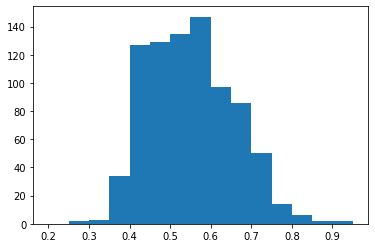

In [31]:
plt.hist(nx.clustering(G).values(),bins=np.arange(0.2,1,0.05))

cantidad de elementos de la matriz: 1022121


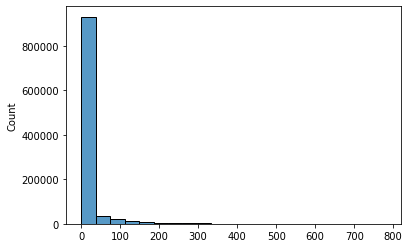

In [32]:
print('cantidad de elementos de la matriz:',len(mat_ady.flatten()))
sns.histplot(mat_ady.flatten())

la mayoría no tiene comunicaciones

In [21]:
#list(G.nodes)
#list(G.edges)
#list(G.adj[1])

¿cuantos tuvieron mas de 200 comunicaciones en ese rango de tiempo?

In [33]:
min_comm=200
g_list=[]
for (u, v, wt) in G.edges.data('weight'):
    if wt > min_comm:
        g_list.append([u,v,wt])
        #print(f"({u}, {v}, {wt})")

pd.DataFrame(g_list).rename(columns={0:'from',1:'to',2:'w'}).T

,0,1,2,3,4,5,6,7,8,9,...,6921,6922,6923,6924,6925,6926,6927,6928,6929,6930
from,1,1,1,1,1,1,2,2,2,2,...,986,987,987,988,989,996,996,998,998,1005
to,372,555,675,731,888,1007,69,126,136,149,...,991,988,1004,1004,990,998,1006,1006,1007,1006
w,210,348,298,214,218,270,406,272,292,284,...,218,646,216,502,344,712,642,548,244,660
